Implementing LDA with Gibbs Sampling<br />
ref: <a href='http://www.ncbi.nlm.nih.gov/pmc/articles/PMC387300/'>Griffiths &amp; Steyvers (2004)</a>, also <a href='http://psiexp.ss.uci.edu/research/papers/SteyversGriffithsLSABookFormatted.pdf'>this book chapter</a><br /><br />

Latent Dirichlet Allocation (LDA) aims to determine:<br /> 
<ol>
<li>the best distribution of $T$ topics to accurately describe the content of a given document (out of a corpus of $D$ documents)</li>
<li>the best distribution of $W$ words to accurately describe each topic</li>
</ol>

In the general case of topic modeling (not LDA-specific), we want to compute: $$P(w_i)=\sum_{j=1}^{T}P(w_i|z_i=j)P(z_i=j)$$
Where: $z_i$ is a latent variable indicating the topic from which the $i$th word was drawn,
$P(w_i|z_i=j)$ is the probability of the word $w_i$ under the $j$th topic,
$P(z_i=j)$ gives the probability of choosing a word from topics $j$ in the current document, which will vary across different documents. <br /><br />
$P(w|z)$ indicates which words are important to a topic, whereas $P(z)$ is the prevalence of those topics within a document.<br /><br />
We assign $P(w|z=j)\equiv\phi_w^{(j)}$ and $P(z=j)\equiv\theta_j^{(d)}$ for notational convenience. <br /><br />
With LDA, we maximize: $$P(w|\phi,\alpha)=\int{P(w|\phi,\theta)P(\theta|\alpha)d\theta}, \theta\sim{Dirichlet(\alpha)}$$

As per Griffiths &amp; Steyvers, we can also estimate $\phi$ as $\phi\sim{Dirichlet(\beta)}$.<br /><br /> 
Our random variables are:
$$w_i|z_i,\phi^{(z_i)}\sim{Multinomial(\phi^{(z_i)})}$$
$$\phi\sim{Dirichlet(\beta)}$$
$$z_i|\theta^{(d_i)}\sim{Multinomial(\theta^{(d_i)})}$$
$$\theta\sim{Dirichlet(\alpha)}$$<br />
Our fixed hyperparameters are $\alpha,\beta$.<br />
Suggested values for hyperparameters: $\alpha =50/T, \beta = 0.01$ (<a href='http://psiexp.ss.uci.edu/research/papers/SteyversGriffithsLSABookFormatted.pdf'>ref</a>)<br /><br />
For LDA, we are interested in the posterior distribution:
$$P(z|w)=\frac{P(w,z)}{\sum_zP(w,z)}$$
There are a couple of challenges we face with this formula.<br />
First, how to compute the joint distribution $P(w,z)=P(w|z)P(z)$? <br />
Recall that $\theta$ and $\phi$ are each only in one of the two expressions in this product. So we can separately integrate out each variable to get what we want.  Integrating out $\phi$ gives:
$$P(w|z)=\left(\frac{\Gamma(W\beta)}{\Gamma(\beta^W)}\right)^T\prod_{j=1}^T\frac{\prod_w\Gamma(n_j^{(w)})+\beta}{\Gamma(n_j^{(\cdot)}+W\beta)}$$
where $n_j^{(\cdot)}$ is the number of times word $w$ has been assigned to topic $j$ in the vector of assignments $z$<br /><br />
Integrating out $\theta$ gives us:
$$P(z)=\left(\frac{\Gamma(T\alpha)}{\Gamma(\alpha^T)}\right)^T\prod_{d=1}^D\frac{\prod_j\Gamma(n_j^{(d)})+\alpha}{\Gamma(n_.^{(d)}+T\alpha)}$$
where $n_j^{(d)}$ is the number of times a word from document $d$ has been assigned to topic $j$. <br /><br />
We can use a Gibbs sampler to estimate our target posterior if we have the conditional distribution.  This can be derived by cancelling out terms in the above two expressions, to give:
$$P(z_i=j|z_{-i},w)\propto\frac{n_{-i,j}^{(w_i)}+\beta}{n_{-i,j}^{(\cdot)}+W\beta}\frac{n_{-i,j}^{(d_i)}+\alpha}{n_{-i,\cdot}^{(d_i)}+T\alpha}$$
where $n_{-i,j}^{(\cdot)}$ is a count that does not include the current assignment of $z_i$. The first ratio expresses the probability of $w_i$ under topic $j$, and the second ratio expresses the probability of topic $j$ in document $d_i$.
<br /><br />
After all documents have been iterated over, and all words in all documents have topics assigned, we can make estimates of $\hat{\phi_i^{(j)}}$ and $\hat{\theta_j^{(d)}}$ via our count matrices:
$$\hat{\phi_i^{(j)}}=\frac{Cwt_{ij}^{WT}+\beta}{\sum_{k=1}^{W}Cwt_{kj}^{WT}+W\beta}$$

$$\hat{\theta_j^{(d)}}=\frac{Cdt_{dj}^{DT}+\alpha}{\sum_{k=1}^{T}Cdt_{dk}^{DT}+T\alpha}$$

We can iterate over this assignment process as many times as we like - we need some kind of objective function to determine how well we're representing the actual data.  We should base this on our target, namely box office gross revenue.  This might look something like using a  linear regression $\hat{\mu}=\beta^{\top}\phi(x)+\epsilon$, with $\phi(x)$ being the probability vectors of topic-membership across all words in a document. We then compute likelihood of $y=\text{b.o. gross $$}$ by drawing $\hat{y}$ from $\sim\mathcal{N}(\hat{\mu},\sigma^2)$.
<br /><br />
One apparent side effect of Gibbs sampling is that we don't need to ever actually draw from a Dirichlet distribution (despite the implication of the name LDA). Everything can be managed via the above formulations and MCMC.

In [1]:
## load modules

import re
import json
import time
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from bs4 import BeautifulSoup as soup
from sklearn.feature_extraction.text import CountVectorizer
from itertools import *
from scipy.special import gammaln

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
## load data

## get movie titles
titles = pd.read_table('lda-data/movietitles/titlesall.csv',header=None,names=["title"])
## get movie reviews
## csv is actually __-separated (double underscore)
data   = pd.read_csv('lda-data/reviews/reviewsall.csv',sep="__",header=None)


/Users/andrew/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.


In [3]:
## get rid of missing values
data.replace(to_replace='^None', value='', inplace=True, regex=True)
data.replace(to_replace=np.nan, value='', inplace=True, regex=True)

## custom stop words from visual inspection
my_stop_words = [' just ',' makes',' comes ',' know ',' quite ',' really ',' going ',' thing ',' screen ',' people ',' does ']
data = data.replace(to_replace=my_stop_words, value=['','','','','','','','','','',''],regex=True)

## collapsed puts all movie reviews together as one long document per movie (each row in df is one movie)
collapsed = np.empty(data.shape[0],dtype="object")
for i in xrange(data.shape[0]):
    try:
        collapsed[i] = data.ix[i,:].sum() # concatenate all reviews for a movie
    except:
        print 'fail'
        print data.ix[i,:]
        print data.ix[i,:].sum()
        break

In [4]:
## create bag of words for entire corpus

# note params: min_df/max_df set bounds on corpus frequency
## WE CAN/SHOULD TUNE THIS VECTORIZATION
vectorizer = CountVectorizer(min_df=.01,max_df=0.5, stop_words='english')

# call `fit` to build the vocabulary
vectorizer.fit(collapsed)
# call `transform` to convert text to a bag of words
X = vectorizer.transform(collapsed)
# CountVectorizer uses a sparse array to save memory, but it's easier to convert back to a "normal" numpy array
X = X.toarray()

In [5]:
## store count-vectorized data for each document in a dict
documents = {}

for d,doc in enumerate(X):
    if d%100==0:
        print 'Doc '+str(d)    
    output = [np.repeat(ix,ct) for ix,ct in enumerate(doc) if ct > 0]
    documents[d] = np.fromiter(chain.from_iterable(output), dtype='int')

Doc 0
Doc 100
Doc 200
Doc 300
Doc 400
Doc 500
Doc 600
Doc 700
Doc 800
Doc 900
Doc 1000
Doc 1100
Doc 1200
Doc 1300
Doc 1400
Doc 1500


In [6]:
## LDA ##

## based on Steyvers & Griffiths (2004)
## with help from: https://gist.github.com/mblondel/542786
##                 https://gist.github.com/ChangUk/a741e0ccf5737954956e

# get index of new topic (z)
def propose_new_z(p,T):
    return np.random.choice(a=xrange(T),p=p)

def calc_conditional(Cwt,Cdt,nd,nt,z,d,T,W,w,b,a):
        
    left  = (Cwt[w,:] + b) / (nt    + W*b)
    right = (Cdt[d,:]   + a) / (nd[d] + T*a)
    pz = left * right
    proba = pz / np.sum(pz)
    return proba    

def gibbs(N,mat,D,W,T,alpha,beta,doPrint=False):
         
    Cdt    = np.zeros((D,T)) # MATRIX: docs  x topics
    Cwt    = np.zeros((W,T)) # MATRIX: words x topics
    nt     = np.zeros(T)     # ARRAY:  topic assignments count
    nd     = np.zeros(D)     # ARRAY:  doc assignments count
    topics = {}              # DICT:   topic labels, organized by tuple: (doc,word_token_i)
          
    ## random initialization
    for d in xrange(D):
        for i,w in enumerate(mat[d]):      
            z             = np.random.randint(T) # randomly choose topic
            Cdt[d,z]     += 1
            nd[d]        += 1
            Cwt[w,z]     += 1
            nt[z]        += 1
            topics[(d,i)] = z  

    liks=[]
    for n in xrange(N):
        for d in xrange(D):
            if doPrint and (d%100==0):
                print 'sampling document: '+str(d)
         
            for i,w in enumerate(mat[d]):
                
                z = topics[(d,i)]
                Cdt[d,z] -= 1
                nd[d]    -= 1
                Cwt[w,z] -= 1
                nt[z]    -= 1

                pz = calc_conditional(Cwt,Cdt,nd,nt,z,d,T,W,w,beta,alpha)
                zstar = propose_new_z(pz,T)

                Cdt[d,zstar] += 1
                nd[d]        += 1
                Cwt[w,zstar] += 1
                nt[zstar]    += 1  
                
                topics[(d,i)] = zstar
        phi, theta = calc_theta_phi(Cwt,Cdt,nd,nt,z,d,w,D,W,T,alpha,beta)
        liks.append(compute_likelihood(Cwt,Cdt,T,D,W,alpha,beta))
        
    return liks, phi, theta
          

def calc_theta_phi(Cwt,Cdt,nd,nt,z,d,w,D,W,T,alpha,beta):
    ph = np.zeros((W,T))                   
    th = np.zeros((D,T))                     
    for d in xrange(D):
        for z in xrange(T):
            th[d][z] = (Cdt[d,z] + alpha) / (nd[d] + T*alpha)
    for z in xrange(T):
        for w in xrange(W):
            ph[w,z] = (Cwt[w,z] + beta) / (nt[z] + W*beta)
    return ph, th    

## goodness of fit: log-likelihood for overall model (find best number of topics)
def log_multi_beta(alpha, K=None):
    """
    Logarithm of the multinomial beta function.
    """
    if K is None:
        # alpha is assumed to be a vector
        return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))
    else:
        # alpha is assumed to be a scalar
        return K * gammaln(alpha) - gammaln(K*alpha)
    
def compute_likelihood(wt,dt,T,D,W,alpha,beta):
    """
    Compute the likelihood that the model generated the data.
    """
    lik = 0

    for z in xrange(T):
        lik += log_multi_beta(wt[:,z]+beta)
        lik -= log_multi_beta(beta, W)

    for d in xrange(D):
        lik += log_multi_beta(dt[d,:]+alpha)
        lik -= log_multi_beta(alpha, T)
        
    return lik

In [7]:
## LDA PARAMETERS

Ts   = [100] # num topics
n    = 80
Nsim = 80              # num simulations
D    = X.shape[0]      # num docs
W    = X.shape[1]      # num unique words

num_words_per_topic = 30 # how many words should we save to topwords csv?

likelihoods = {}
phis        = {}
thetas      = {}


## SETUP FOR ALL-MODELS-IN-ONE DF (not implemented)
#start_indices = [0,2,6,16,86]
#master_phi = np.zeros((W,len(colnames)))
#master_theta = np.zeros((D,len(colnames)))

In [9]:
for ix,T in enumerate(Ts):
    colnames = []
    for t in xrange(T):
        colnames.append('t'+str(t))
        
    a    = 50/float(T)  # alpha
    b    = 0.1          # beta
    ## alpha and betas values recommended by Steyvers & Griffiths 2004
    
    ## timing each model computation
    print 'T='+str(T)+' START: '+str(datetime.now())
    
    ## run lda
    likelihoods[T], phis[T], thetas[T] = gibbs(Nsim,documents,D,W,T,a,b)
    
    ## timing
    print 'T='+str(T)+' END: '+str(datetime.now())
    ## print likelihood (necessary?)
    print 'Best likelihood: {blik}'.format(blik=likelihoods[T][Nsim-1])
    
    ## ALL-MODELS-IN-ONE (not implemented)
    #try:
    #    master_phi[:,start_indices[ix]:start_indices[ix+1]] = phis[T]
    #    master_theta[:,start_indices[ix]:start_indices[ix+1]] = thetas[T]
    #except:
    #    print 'master assignment failed.'
        
    ## make phi matrix (words x topics)
    phi_df = pd.DataFrame(phis[T],columns=colnames,index=vectorizer.get_feature_names())
    ## save to csv
    phi_df.to_csv('lda-data/gibbs/phi/phi-df{t}.csv'.format(t=T),index=False)
    
    ## save phi and theta matrices from final iteration
    np.savetxt('lda-data/gibbs/rawphi/phis-{t}.csv'.format(t=T),phis[T],delimiter=",")
    np.savetxt('lda-data/gibbs/rawtheta/thetas-{t}.csv'.format(t=T),thetas[T],delimiter=",")
    
    ## initialize matrix to hold X words per topic
    words_per_topic = np.empty((T,num_words_per_topic),dtype=object)

    ## topic checker
    for i,topic in enumerate(phi_df): 
        words_per_topic[i,:] = phi_df.sort(topic,ascending=False)[topic].head(num_words_per_topic).index

    ## top words per topic
    top_topic_words = pd.DataFrame(words_per_topic.T)
    top_topic_words.columns = colnames

    ## write top words per topic df to csv
    top_topic_words.to_csv('lda-data/topwords/top-words-per-topic{t}.csv'.format(t=T),index=False)
    
    ## thetas = doc x topics matrix
    ## create theta dataframe
    theta_df = pd.DataFrame(thetas[T],columns=colnames)
    ## write to csv
    theta_df.to_csv('lda-data/gibbs/theta/theta-df{t}.csv'.format(t=T),index=False)

T=100 START: 2016-02-23 19:53:02.772017
T=100 END: 2016-02-23 20:10:25.063452
Best likelihood: -1777453.63222


/Users/andrew/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


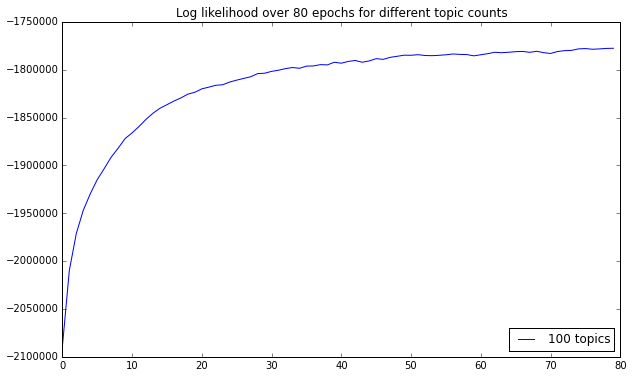

In [10]:
## likelihood improvement curve over 100 iterations for T=10
plt.figure(figsize=(10,6))
for T in Ts:
    plt.plot(likelihoods[T], label=str(T)+' topics')
_=plt.legend(loc="lower right",labelspacing=.1)
_=plt.title("Log likelihood over 80 epochs for different topic counts")

### Code below is same as code in actual LDA loop above, but we can run it without re-running LDA if tweaks are necessary to output files.

In [10]:
phidf2 = pd.read_csv('lda-data/gibbs/phi/phi-df2.csv')

In [12]:
phidf2.shape

(3040, 2)

In [100]:
num_words_per_topic = 30
for T in Ts:
    ## make word-topic df
    colnames = ['t'+str(i) for i in xrange(T)]
    
    ## make phi matrix (words x topics)
    phi_df = pd.DataFrame(phis[T],columns=colnames,index=vectorizer.get_feature_names())
    ## save to csv
    phi_df.to_csv('lda-data/gibbs/phi/phi-df{t}.csv'.format(t=T),index=False)
    
    ## save phi and theta matrices from final iteration
    np.savetxt('lda-data/gibbs/rawphi/phis-{t}.csv'.format(t=T),phis[T],delimiter=",")
    np.savetxt('lda-data/gibbs/rawtheta/thetas-{t}.csv'.format(t=T),thetas[T],delimiter=",")
    
    ## initialize matrix to hold X words per topic
    words_per_topic = np.empty((T,num_words_per_topic),dtype=object)

    ## topic checker
    for i,topic in enumerate(phi_df): 
        words_per_topic[i,:] = phi_df.sort(topic,ascending=False)[topic].head(num_words_per_topic).index

    ## top words per topic
    top_topic_words = pd.DataFrame(words_per_topic.T)
    top_topic_words.columns = colnames

    ## write top words per topic df to csv
    top_topic_words.to_csv('lda-data/topwords/top-words-per-topic{t}.csv'.format(t=T),index=False)
    
    ## thetas = doc x topics matrix
    ## create theta dataframe
    theta_df = pd.DataFrame(thetas[T],columns=colnames)
    ## write to csv
    theta_df.to_csv('lda-data/gibbs/theta/theta-df{t}.csv'.format(t=T),index=False)
    